<a href="https://colab.research.google.com/github/opsaran/image_identifier/blob/main/identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.di.ens.fr/~lelarge/MNIST.tar.gz

--2023-01-22 04:18:04--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.6MB/s    in 2.9s    

2023-01-22 04:18:08 (11.6 MB/s) - ‘MNIST.tar.gz’ saved [34813078]



In [2]:
!tar -xzvf "MNIST.tar.gz" "MNIST"

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte.gz
MNIST/processed/
MNIST/processed/training.pt
MNIST/processed/test.pt


In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
x, y = torch.load('MNIST/processed/training.pt')

In [ ]:
x.shape

torch.Size([60000, 28, 28])

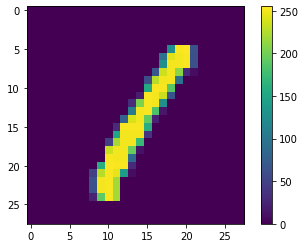

In [ ]:
plt.imshow(x[3].numpy())
plt.colorbar()
plt.show()

In [ ]:
y[3].numpy()

array(1)

In [ ]:

y_new = F.one_hot(y, num_classes = 10)
y_new

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

In [ ]:
x.view(-1,28**2).shape

torch.Size([60000, 784])

In [5]:
class CTDataset(Dataset):
  def __init__(self, filepath):
    self.x,self.y = torch.load(filepath)
    self.x = self.x / 255
    self.y = F.one_hot(self.y, num_classes = 10).to(float)
  def __len__(self):
    return self.x.shape[0]
  def __getitem__(self,ix):
    return self.x[ix], self.y[ix]
  

In [6]:
train_ds = CTDataset('MNIST/processed/training.pt')
test_ds = CTDataset('MNIST/processed/test.pt')

In [7]:
train_dl = DataLoader(train_ds, batch_size=5)

In [8]:
for x,y in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([5, 28, 28])
torch.Size([5, 10])


In [12]:
len(train_dl)

12000

In [13]:
class MyNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.M1 = nn.Linear(28**2,100)
    self.M2 = nn.Linear(100,50)
    self.M3 = nn.Linear(50,10)
    self.R = nn.ReLU()
  def forward(self,x):
    x= x.view(-1,28**2)
    x= self.R(self.M1(x))
    x= self.R(self.M2(x))
    x= self.M3(x)
    return x.squeeze()


In [14]:
xs,ys = train_ds[0:4]

In [15]:
xs.shape

torch.Size([4, 28, 28])

In [16]:
ys.shape

torch.Size([4, 10])

In [17]:
f= MyNeuralNet()

In [21]:
f(xs)

tensor([[ 0.0151,  0.0889,  0.1426, -0.1009, -0.0524,  0.1117,  0.0216, -0.1086,
          0.1404,  0.1053],
        [ 0.0368,  0.0773,  0.1370, -0.0976, -0.0546,  0.1032,  0.0570, -0.0783,
          0.1161,  0.0889],
        [ 0.0235,  0.0093,  0.1379, -0.0589, -0.0516,  0.0975,  0.0529, -0.0831,
          0.1286,  0.0940],
        [ 0.0066,  0.0661,  0.1582, -0.0860, -0.0819,  0.1329,  0.0269, -0.0377,
          0.1413,  0.0962]], grad_fn=<SqueezeBackward0>)

In [20]:
ys

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [27]:
def train_model(dl,f,n_epochs=20):
  opt = SGD(f.parameters(), lr=0.01)
  L = nn.CrossEntropyLoss()

  losses = []
  epochs = []
  for epoch in range(n_epochs):
    print(f'epoch {epoch}')
    N = len(dl)
    for i, (x,y) in enumerate(dl):
      opt.zero_grad()
      loss_value = L(f(x),y)
      loss_value.backward()
      opt.step()
      epochs.append(epoch+i/N)
      losses.append(loss_value.item())
  return np.array(epochs), np.array(losses)


In [28]:
epoch_data, losses_data = train_model(train_dl,f)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19


Text(0.5, 1.0, 'cross entropy per batch')

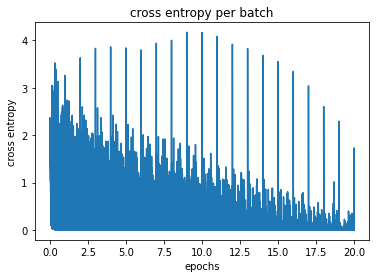

In [29]:
plt.plot(epoch_data,losses_data)
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title("cross entropy per batch")

In [30]:
epoch_data.shape

(240000,)

In [31]:
losses_data.shape

(240000,)

In [34]:
loss_data_avg = losses_data.reshape(20,-1).mean(axis=1)
epoch_data_avg = epoch_data.reshape(20,-1).mean(axis=1)

Text(0, 0.5, 'cross entropy')

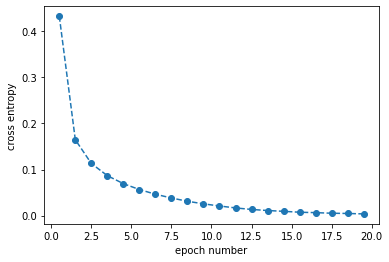

In [37]:
plt.plot(epoch_data_avg, loss_data_avg,'o--')
plt.xlabel('epoch number')
plt.ylabel('cross entropy')

In [40]:
y_sample = train_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [41]:
x_sample = train_ds[0][0]
yhat_sample = f(x_sample)
yhat_sample

tensor([ -8.9567,  -1.1557,  -2.0079,  23.4722, -21.0558,  31.4757, -16.2376,
         -2.5525,  -5.0502,   9.8797], grad_fn=<SqueezeBackward0>)

In [42]:
yhat_sample.argmax()

tensor(5)

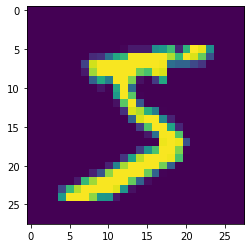

In [43]:
plt.imshow(x_sample)

In [44]:
xs,ys = train_ds[0:2000]

In [46]:
ys.shape

torch.Size([2000, 10])

In [49]:
yhat = f(xs).argmax(axis=1)
yhat

tensor([5, 0, 4,  ..., 5, 2, 0])

In [50]:
ys

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

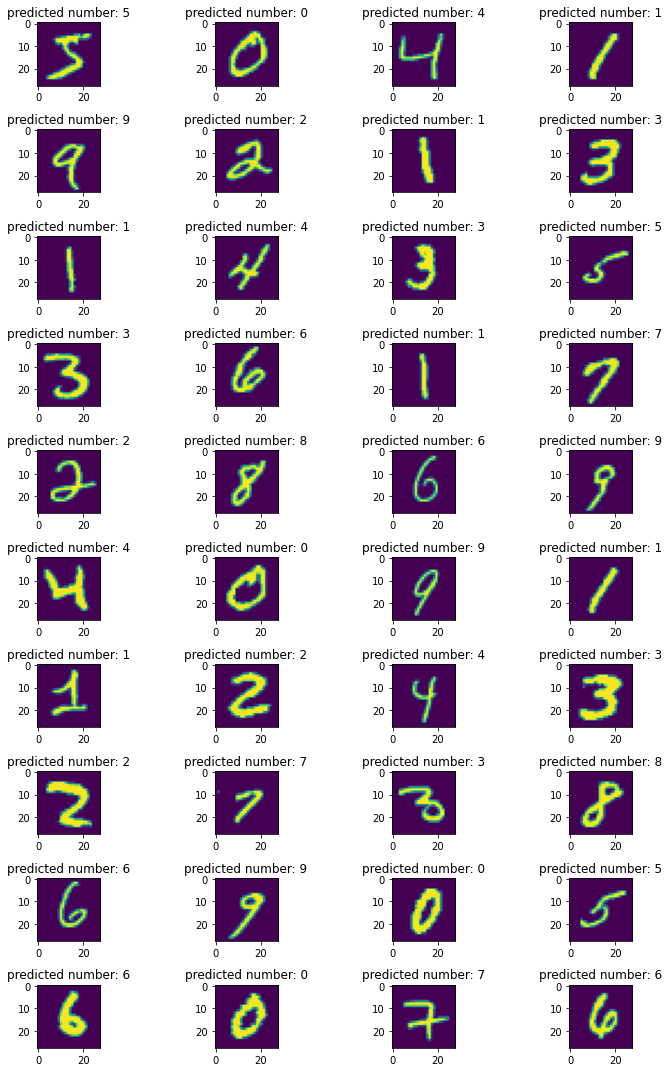

In [51]:
fig,ax = plt.subplots(10,4, figsize=(10,15))
for i in range(40):
  plt.subplot(10,4,i+1)
  plt.imshow(xs[i])
  plt.title(f'predicted number: {yhat[i]}')
fig.tight_layout()
plt.show()

In [52]:
xs,ys = test_ds[:2000]

In [53]:
yhat = f(xs).argmax(axis=1)

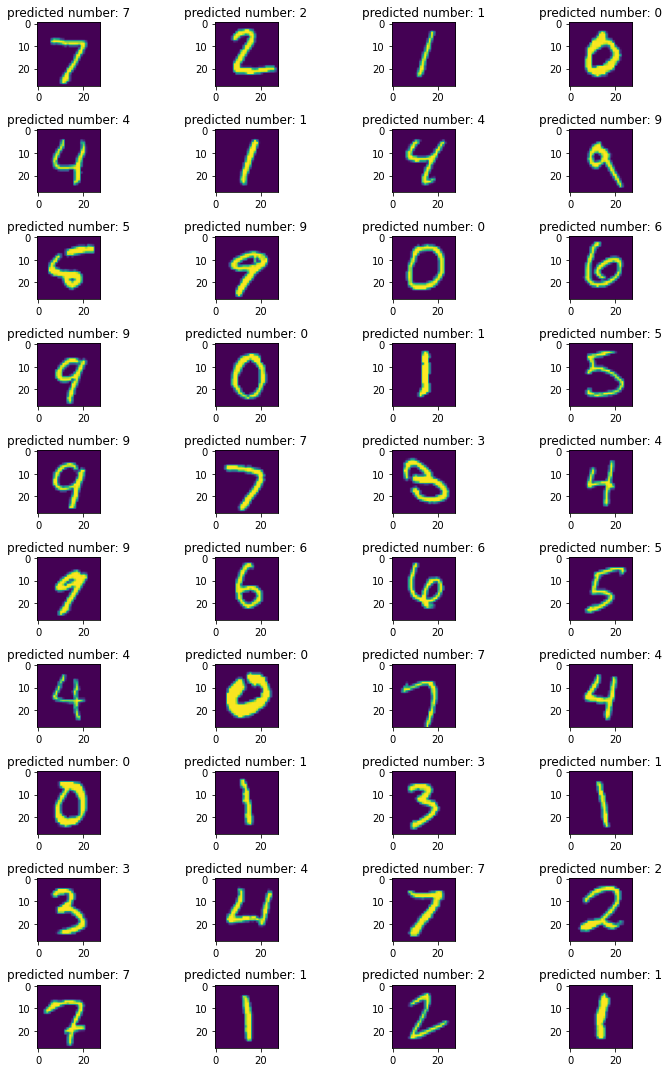

In [54]:
fig,ax = plt.subplots(10,4, figsize=(10,15))
for i in range(40):
  plt.subplot(10,4,i+1)
  plt.imshow(xs[i])
  plt.title(f'predicted number: {yhat[i]}')
fig.tight_layout()
plt.show()